In [58]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
base_path = Path('/content/drive/MyDrive/data')

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

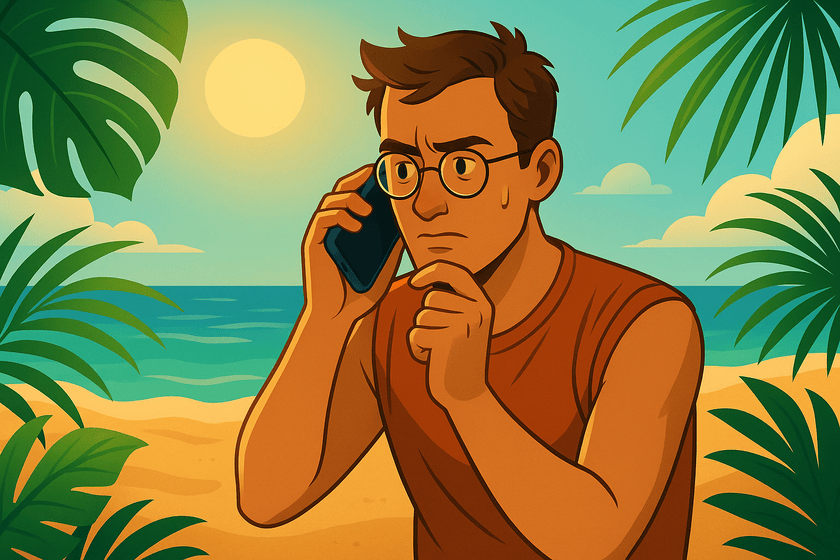

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [60]:
df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

#**1. Przygotwanie danych**


**1.1 Usunięnie zbędnych kolumn**

Kolumy do usunięcia: PassangerId, Name, Ticket

In [61]:
df.drop('Ticket', axis=1, inplace=True)
df.drop('Name', axis=1, inplace=True)
df = df.reset_index()
df.drop('PassengerId', axis=1, inplace=True)

**1.2 Uzupełnienie Age i Fare, nałożenie logarytmu**

Age i fare uzupełniam medianą - medianę w fare biorę dla każdej klasy podróży oddzielnie

In [62]:
missing_age_vals = df['Age'].isna()
age_median = df['Age'].median()

df.loc[missing_age_vals, 'Age'] = age_median

missing_fare_vals = df['Fare'].isna()
classList = df['Pclass'].unique()

for Pclass in classList:
  fare_median = df[df['Pclass'] == Pclass]['Fare'].median()
  df.loc[missing_fare_vals & (df['Pclass'] == Pclass), 'Fare'] = fare_median

Ze względu na to, że dystrybucja Fare jest zdecydowanie skupiona przy niskich wartościach, ale występują odległe outlinery, można nałożyć na nią logarytm, dzięki czemu standaryzacja i normalizacja będą bardziej skuteczne.

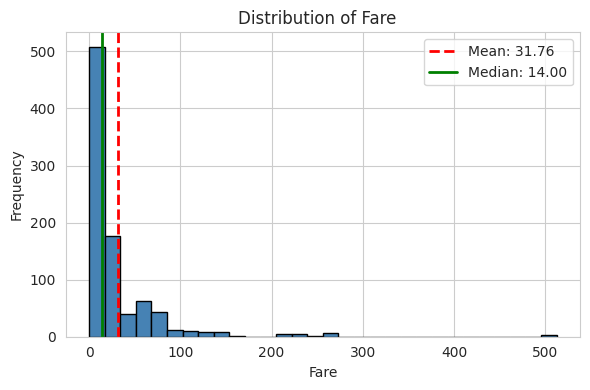

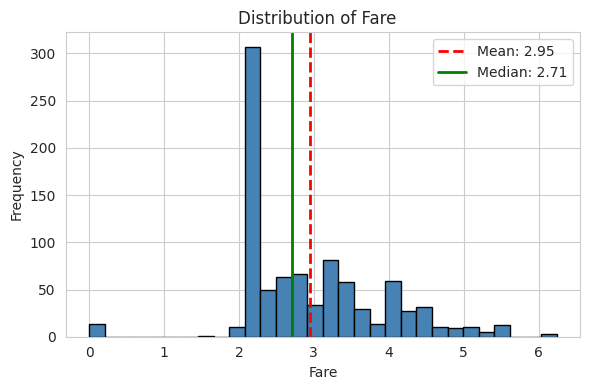

In [63]:
def plot_numeric_histogram(df, column_name, info = ''):

  data = df[column_name].dropna()

  mean_val = data.mean()
  median_val = data.median()

  plt.figure(figsize=(6, 4))
  plt.hist(data, bins=30, color='steelblue', edgecolor='black')
  plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
  plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

  plt.title(f'Distribution of {column_name} {info} ')
  plt.xlabel(column_name)
  plt.ylabel('Frequency')
  plt.legend()
  plt.tight_layout()
  plt.show()

plot_numeric_histogram(df, column_name='Fare')
df['Fare'] = np.log1p(df['Fare'])
plot_numeric_histogram(df, column_name='Fare')


**1.3 Uzupełnienie Embarked i Cabin**

Braki w kolumnie Embraked są niewielkie - w miejsce brakujących danych wstawiam modę

W kolumnie Cabin braki to blisko 75% - w istniejących danych można zauważyć, że pierwszy znak w wartościach w tej kategori to określony obszar na statku - to może mieć znaczenie w predykcji. W istniejących danych z kabin zostawiam jedynie litery oznaczające sektory na statku, a brakujące dane uzupełniam sztucznym sektorem 'X' - w kodowaniu one hot, obecność tej kategori można rozumieć jako flaga unknown

In [64]:
missing_embarked_vals = df['Embarked'].isna()
embarked_mode = df['Embarked'].mode()[0]
df.loc[missing_embarked_vals, 'Embarked'] = embarked_mode

df['Cabin'] = df['Cabin'].str[0]
df['Cabin'] = df['Cabin'].fillna('X')

df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,2.110213,X,S
1,1,1,female,38.0,1,0,4.280593,C,C
2,1,3,female,26.0,0,0,2.188856,X,S
3,1,1,female,35.0,1,0,3.990834,C,S
4,0,3,male,35.0,0,0,2.202765,X,S


**1.4 Dodanie kolumn**

Dodaje kolumnę Alone - wskazuje, czy dana osoba podróżowała sama czy w towarzystiwe rodziny

In [65]:
alone_fun = lambda x: 1 - min(x['SibSp'] + x['Parch'], 1)
df['Alone'] = df.apply(alone_fun, axis=1)

**1.5 Zmiana typów i zakodowanie one hot**

In [66]:
df['Sex'] = df['Sex'].map({'male': False, 'female': True})
df['Survived'] = df['Survived'].astype(bool)
df['Alone'] = df['Alone'].astype(bool)
df = pd.get_dummies(df, columns=['Embarked'], drop_first=False)
df = pd.get_dummies(df, columns=['Cabin'], drop_first=False)

#**2. Zastosowanie Modeli**

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, accuracy_score, f1_score

def single_training(df, model):
  X = df.drop(columns=['Survived'], axis=1)
  y = df['Survived']

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=True, random_state = 88)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))

def single_trainig_f1score(df, model):
  X = df.drop(columns=['Survived'], axis=1)
  y = df['Survived']

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=True, random_state = 88)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return f1_score(y_test, y_pred, average='weighted')

**2.0 Dummy Classifier**

Aby sprawdzić, czy zastosowany model *wogóle działa* należy porównać uzysakne wyniki z wyniakmi dummy classifiera - klasyfikatora który nie uczy się na danych, a klasyfikuje dane w sposób przypadkowy lub przy użyciu najprostrzych strategii:

*   most_frequent - przewiduje zawsze najczęściej występującą klasę w zbiorze treningowym
*   stratified - przewiduje klasy losowo, z zachowaniem rozkładu z danych treningowych
* unfiform - przewiduje klasy losowo, z rozkładem jednostajnym
* constant - przewiduje zawsze klasę podaną jako stałą w argumencie

In [68]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy = 'stratified')
single_training(df, model)

              precision    recall  f1-score   support

       False       0.68      0.67      0.67       117
        True       0.39      0.40      0.40        62

    accuracy                           0.58       179
   macro avg       0.53      0.53      0.53       179
weighted avg       0.58      0.58      0.58       179



**2.1 SVM - Support Vector Machine**

W celu uzyskania dobrego wyniku dane należy dodatkowo poddać standaryzacji lub normalizacji. Ze źródeł wynika, że dla modelu SVM lepsza jest standaryzacja - by to sprawdzić, badania przeprowadze z dwoma wersjami danych.

Pondato jeśli dane są liniowo separowalne, dobrą skutecznością wykaże się liniowy SVM, natomiast jeśl nie są liniowo separowalne, należy zastosować wersję SVM z jądrem (RBF, polynomial, lub sigmoid).

In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.svm import SVC

cols_to_change = ['Fare', 'Age', 'Pclass', 'SibSp', 'Parch']

scaler = StandardScaler()
df_standard = pd.DataFrame(df)
df_standard[cols_to_change] = scaler.fit_transform(df_standard[cols_to_change])

scaler = MinMaxScaler()
df_normal = pd.DataFrame(df)
df_normal[cols_to_change] = scaler.fit_transform(df_normal[cols_to_change])

In [70]:
#plot_numeric_histogram(df_standard, 'Age')
#plot_numeric_histogram(df_standard, 'Fare')
#plot_numeric_histogram(df_normal, 'Age')
#plot_numeric_histogram(df_normal, 'Fare')

**2.1.1 SVM rbf**

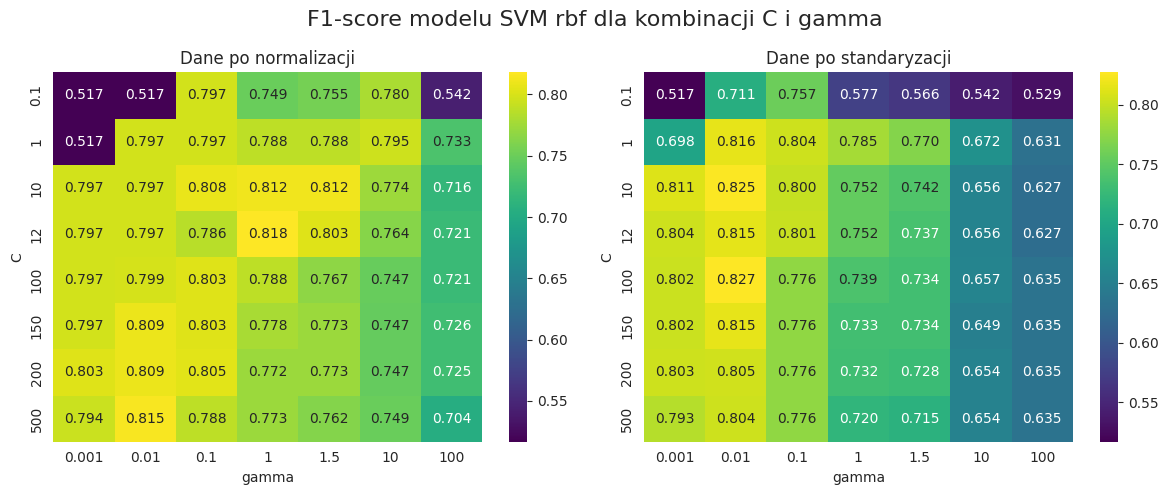

In [47]:
def svm_rbf(df, C, gamma):
  model = SVC(kernel='rbf', C =C, gamma = gamma)
  return single_trainig_f1score(df, model)

def svm_rbf_test(df, values_C, values_gamma):

  rbf_results = np.zeros((len(values_C), len(values_gamma)))

  for i, C in enumerate(values_C):
    for j, gamma in enumerate(values_gamma):
      rbf_results[i][j] = svm_rbf(df, C, gamma)

  return rbf_results

def svm_rbf_test_run(df_normal, df_standard, values_C, values_gamma):

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  sns.heatmap(svm_rbf_test(df_normal, values_C, values_gamma), xticklabels=values_gamma, yticklabels=values_C, annot=True, cmap="viridis", fmt = ".3f", ax = axes[0])
  sns.heatmap(svm_rbf_test(df_standard, values_C, values_gamma), xticklabels=values_gamma, yticklabels=values_C, annot=True, cmap="viridis", fmt = ".3f", ax = axes[1])

  axes[0].set_title("Dane po normalizacji")
  axes[1].set_title("Dane po standaryzacji")

  for i in range(2):
    axes[i].set_xlabel("gamma")
    axes[i].set_ylabel("C")

  fig.suptitle("F1-score modelu SVM rbf dla kombinacji C i gamma", fontsize = 16)
  plt.tight_layout()
  plt.show()

values_C = [0.1, 1, 10, 12, 100, 150, 200, 500]
values_gamma = [0.001, 0.01, 0.1, 1, 1.5, 10, 100]

svm_rbf_test_run(df_normal, df_standard, values_C, values_gamma)


Różnice między wynikami dla dwóch różnych sposobów obróbki danych są zauważalne

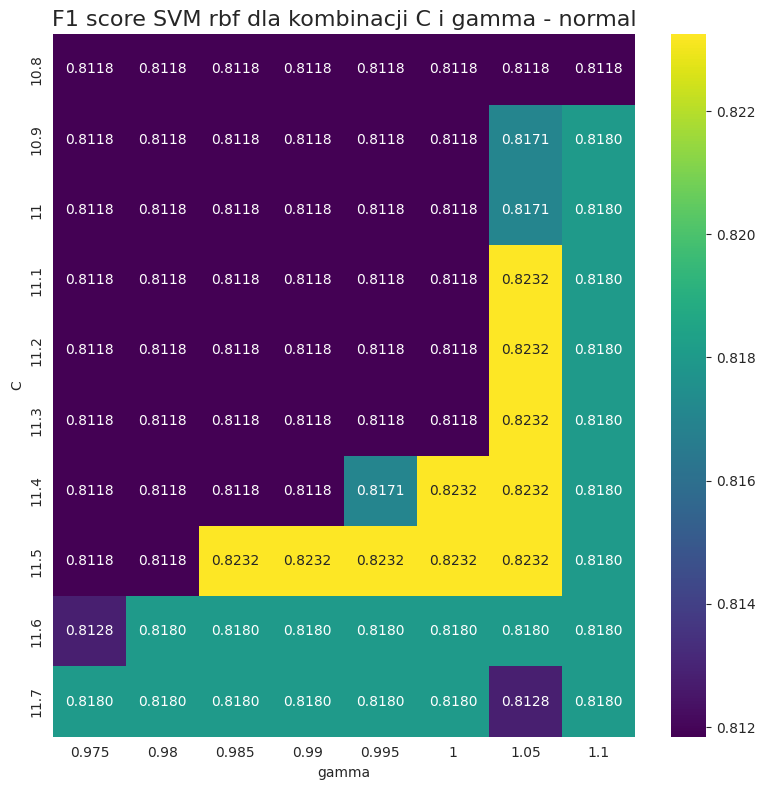

In [48]:
def svm_rbf_specific_test(df, values_C, values_gamma, info = ''):

  plt.figure(figsize=(8, 8))
  sns.heatmap(svm_rbf_test(df, values_C, values_gamma), xticklabels=values_gamma, yticklabels=values_C, annot=True, cmap="viridis", fmt = ".4f")

  plt.xlabel("gamma")
  plt.ylabel("C")

  plt.title(f"F1 score SVM rbf dla kombinacji C i gamma - {info}", fontsize = 16)
  plt.tight_layout()
  plt.show()

values_C = [10.8, 10.9, 11, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7]
values_gamma = [.975, .98, .985, .99, .995, 1, 1.05, 1.1]

svm_rbf_specific_test(df_normal, values_C, values_gamma, info = 'normal')

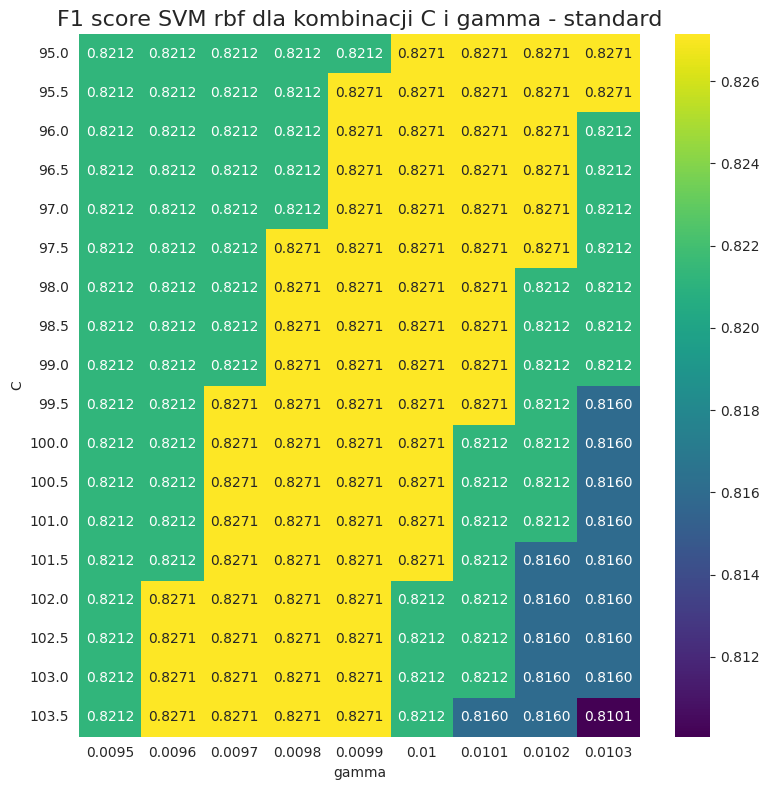

In [49]:

values_C = np.arange(95, 104, 0.5)
values_gamma = [.0095, .0096, .0097, .0098, .0099, .01, .0101, .0102, .0103]

svm_rbf_specific_test(df_standard, values_C, values_gamma, info = 'standard')

Wydaje się, że na przygotowanych danych badany model osiąga najlepsze rezultaty dla danych poddanych standaryzacji i widocznych powyżej wartościach hiperparametrów.

Poniżej przykładowy pełny rezultat dla najkorzystniejszych ustawień parametrów

In [50]:
model = SVC(kernel='rbf', C = 98.5, gamma = 0.01)

single_training(df_standard,model)

              precision    recall  f1-score   support

       False       0.87      0.86      0.87       117
        True       0.75      0.76      0.75        62

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



**2.1.2 SVM linear**

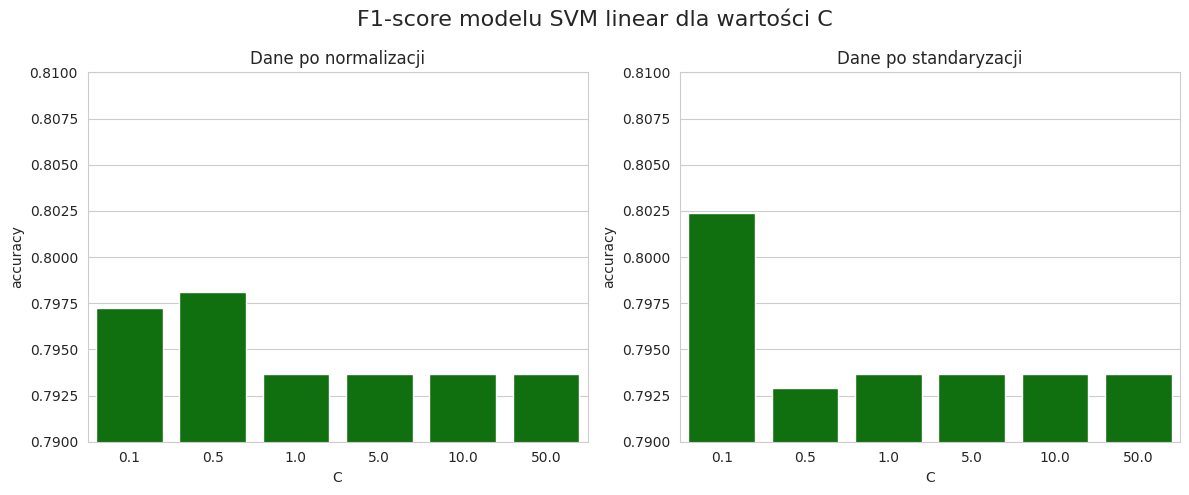

In [51]:
def svm_linear(df, C):
  model = SVC(kernel='linear', C = C)
  return single_trainig_f1score(df, model)

def svm_linear_test_run(df_normal, df_standard, values_C, min_val = 0.79, max_val = 0.81):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  sns.set_style("whitegrid")
  results_standard = [svm_linear(df_standard, C) for C in values_C]
  results_normal = [svm_linear(df_normal, C) for C in values_C]

  sns.barplot(x = values_C, y = results_normal, ax = axes[0], color = 'green')
  sns.barplot(x = values_C, y = results_standard, ax = axes[1], color = 'green')

  axes[0].set_title("Dane po normalizacji")
  axes[1].set_title("Dane po standaryzacji")


  for i in range(2):
    axes[i].set_xlabel("C")
    axes[i].set_ylabel("accuracy")
    axes[i].set_ylim(min_val, max_val)


  fig.suptitle("F1-score modelu SVM linear dla wartości C", fontsize = 16)
  plt.tight_layout()
  plt.show()


values_C = [0.1, 0.5, 1, 5, 10, 50]
svm_linear_test_run(df_normal, df_standard, values_C)


Najprawdopodbniej model działa najelpiej dla C z zakresu (0.1, 1) - bliżej 0.1

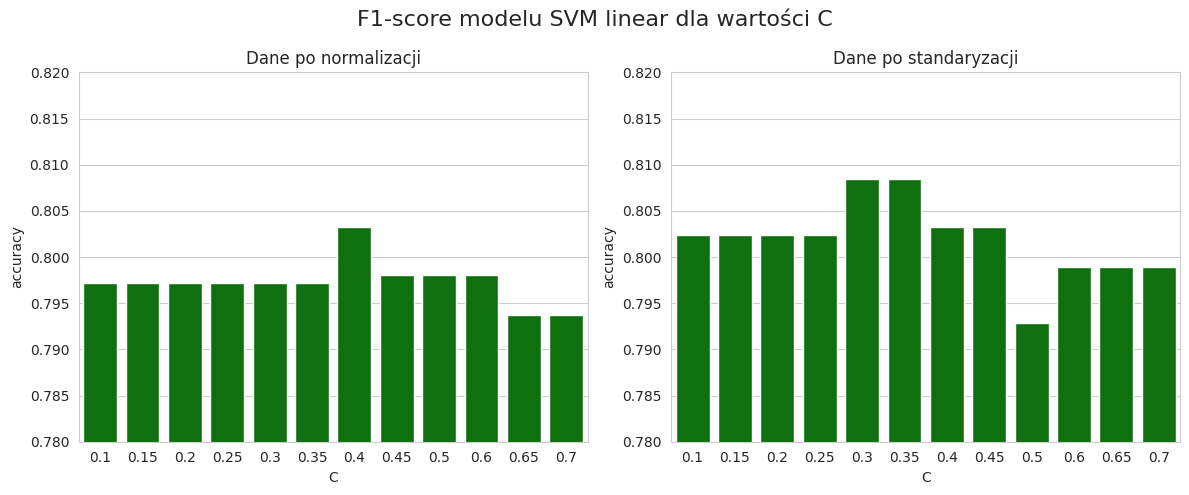

In [52]:
values_C = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7]
svm_linear_test_run(df_normal, df_standard, values_C, min_val = 0.78, max_val = 0.82)

W przypadku liniowego SVM, model działa lepiej dla danych po standaryzacji. Natomiast najwyższy F1-score jest jednak mniejszy niż dla SVM z kernelem rbf, co sugeruje, że dane nie są separowalne liniowo.

**2.1.3 Dane nieskalowane**

W czasie eksperymentowania, zauważyłem, że wbrew oczekwianiom w modelu SVM z kernelem rbf dobrze sprawdzają się dane bez standaryzaji i normalizacji - zauważony f1score jest większy niż uzysakny w pozostałych próbach z SVM. Być może podobny lub lepszy wynik da się uzyskać w skalowanych danych, ale tego nie wiem.

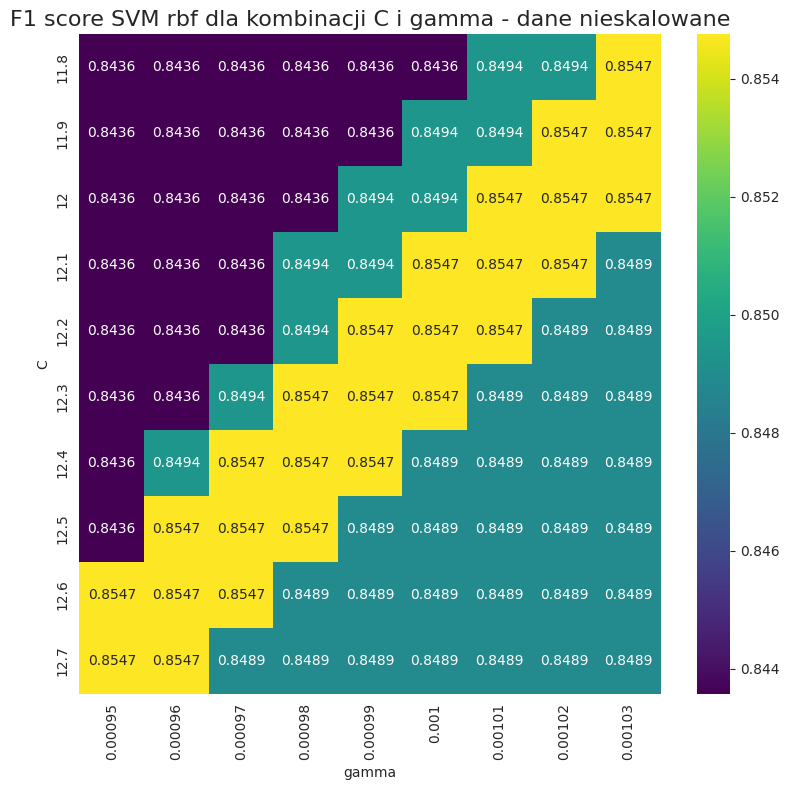

              precision    recall  f1-score   support

       False       0.89      0.89      0.89       117
        True       0.79      0.79      0.79        62

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



In [53]:
values_C = [11.8, 11.9, 12, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7]
values_gamma = [.00095, .00096, .00097, .00098, .00099, .001, .00101, .00102, .00103]

svm_rbf_specific_test(df, values_C, values_gamma, info = 'dane nieskalowane')

model = SVC(kernel='rbf', C = 12.2, gamma = 0.001)

single_training(df,model)

**2.2 KNeighbors**



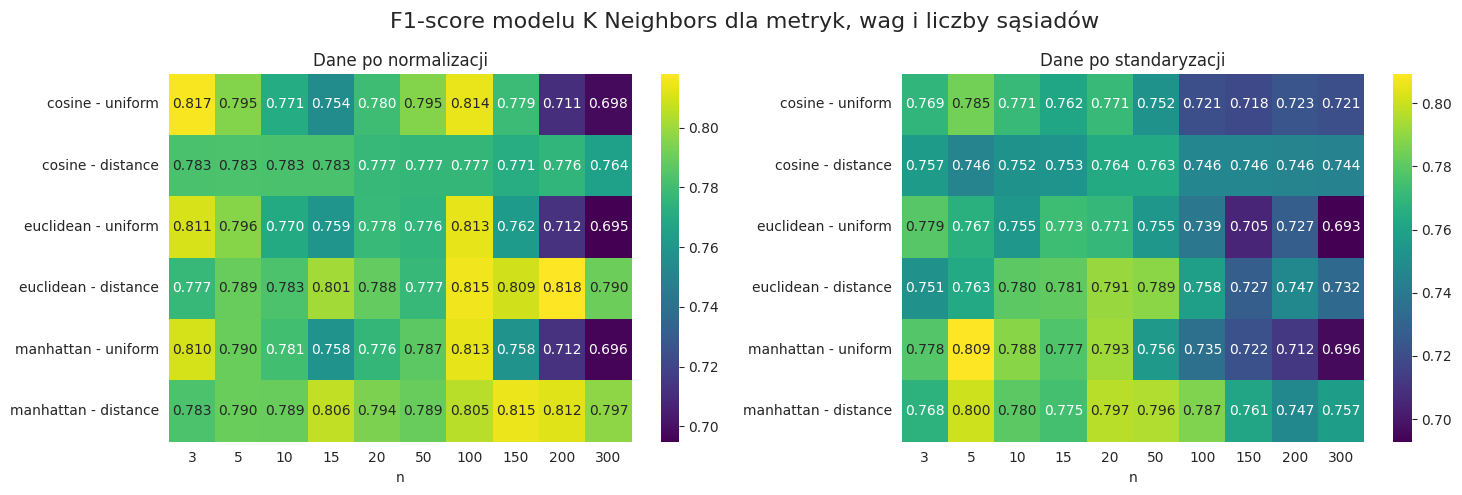

In [54]:
from sklearn.neighbors import KNeighborsClassifier

def k_neighbors(df, n, weights, metric):
  model = KNeighborsClassifier(n_neighbors = n, weights = weights, metric = metric)
  return single_trainig_f1score(df, model)

def k_neighbors_test(df, n_list, setups):

  results = []

  for metric, weight in setups:
    results.append([k_neighbors(df, n, weight, metric) for n in n_list])

  return results

def k_neigbors_tests_run(df_normal, df_standard, metrics, weights, n_list):

  setups = []

  for metric in metrics:
    for weight in weights:
      setups.append([metric, weight])

  results = k_neighbors_test(df_standard, n_list, setups)

  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  y_labels = []
  for metric, weight in setups:
    y_labels.append(f'{metric} - {weight}')

  sns.heatmap(k_neighbors_test(df_normal, n_list, setups), xticklabels=n_list, yticklabels = y_labels, annot=True, cmap="viridis", fmt = ".3f", ax = axes[0])
  sns.heatmap(k_neighbors_test(df_standard, n_list, setups), xticklabels=n_list, yticklabels = y_labels, annot=True, cmap="viridis", fmt = ".3f", ax = axes[1])

  axes[0].set_title("Dane po normalizacji")
  axes[1].set_title("Dane po standaryzacji")

  for i in range(2):
    axes[i].set_xlabel("n")


  fig.suptitle("F1-score modelu K Neighbors dla metryk, wag i liczby sąsiadów", fontsize = 16)
  plt.tight_layout()
  plt.show()

metrics = ['cosine', 'euclidean', 'manhattan']
weights = ['uniform', 'distance']

n_list = [3,5,10,15,20,50,100,150,200,300]

k_neigbors_tests_run(df_normal, df_standard, metrics, weights, n_list)

Przy zastosowaniu modelu K Neighbors wyższą skutecznością zazwyczaj cehcują się modele wytrenowane na danych po normalizacji. Co ciekawe, przy tych samych ustawieniach hiperparmetrów, wartości f1-score są znacząco różne dla róznie wyskalowanych tych samych zbiorów danych.

Na powyższych heatmapach widać skutecznośc modeli w zależności od hiperparametrów - użytej metryki, sposobu ważenia odległości od sąsiadów (uniform - odległość od każdego ma tą samą wagę, distance - waga odległości jest dowrotnie proporcjonalna do jej wartości) i liczby sąsiadów branych pod uwagę.

Przykładowy pełny rezultat  dla najskuteczniejszych zaobserowanych ustawień hiperparametrów:

In [55]:
model = KNeighborsClassifier(n_neighbors = 200, weights = 'distance', metric = 'euclidean')

single_training(df_normal, model)

              precision    recall  f1-score   support

       False       0.84      0.90      0.87       117
        True       0.78      0.68      0.72        62

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



**2.3 Decision Tree**



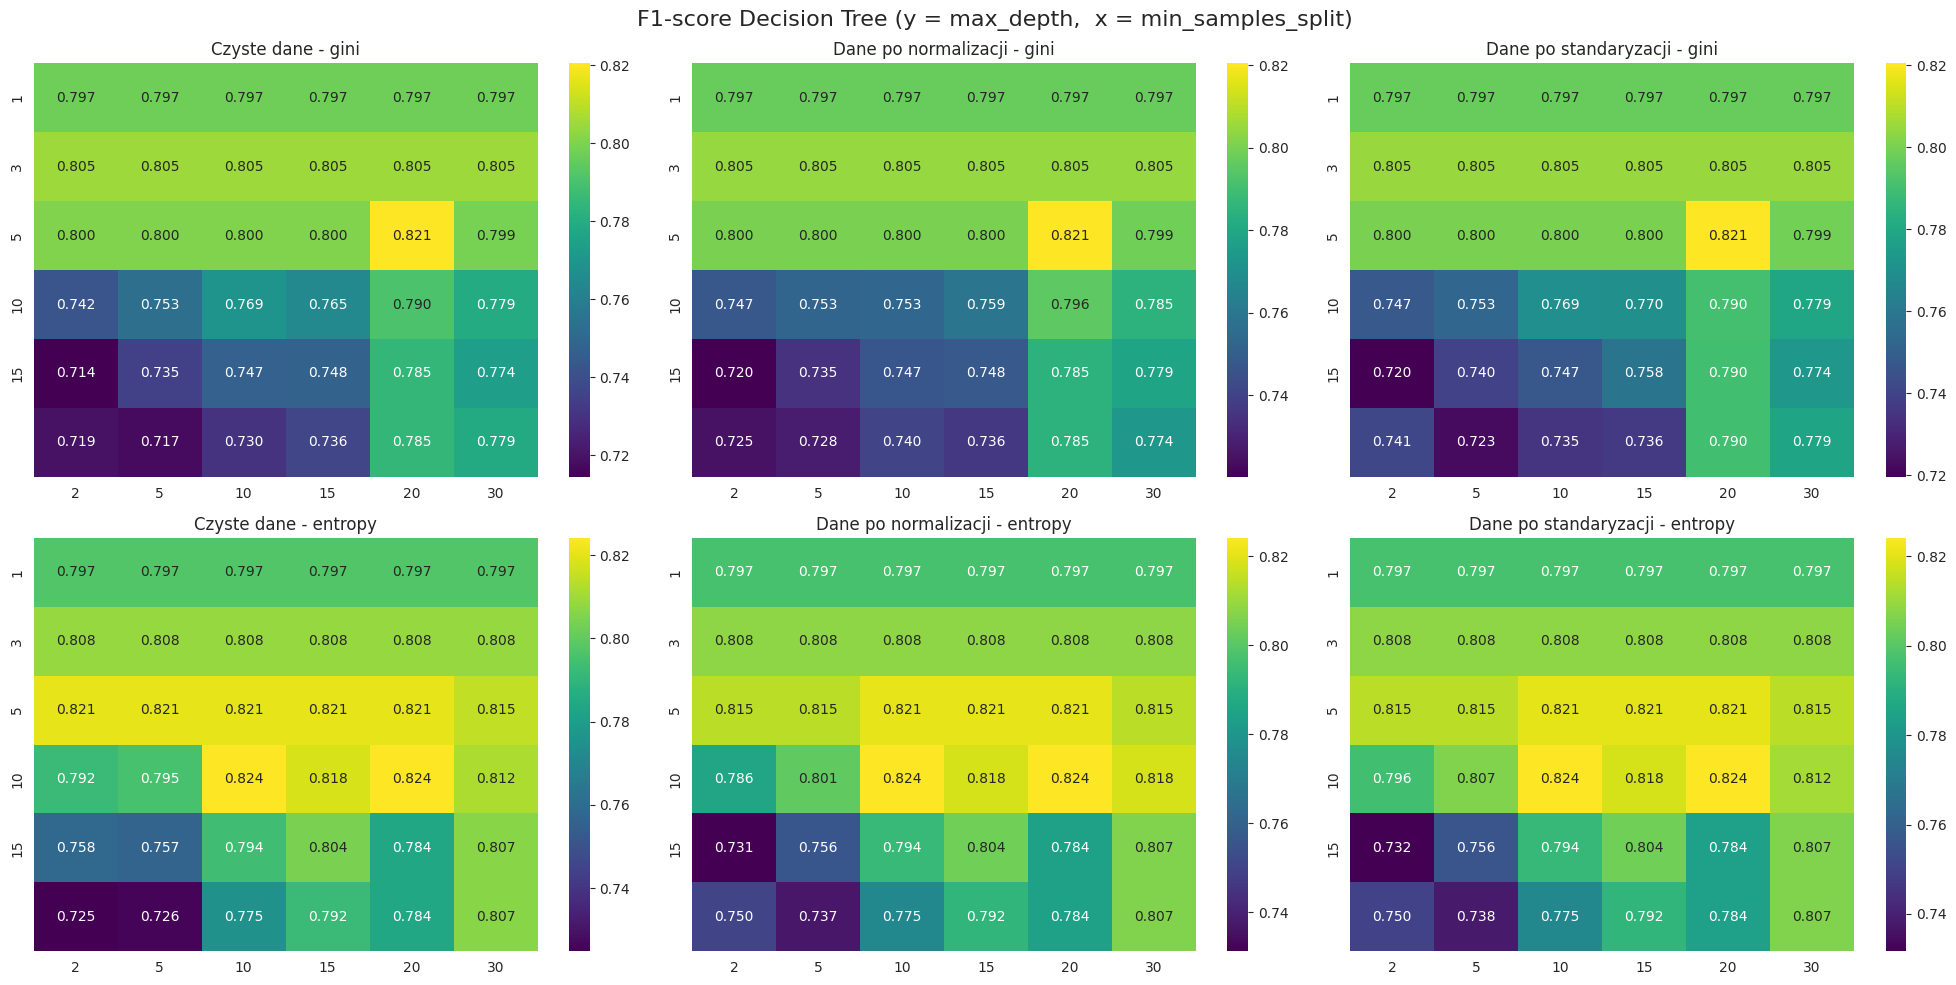

In [56]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(df, max_depth, min_samples_split, criterion):

  model = DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, criterion = criterion)

  return single_trainig_f1score(df, model)

def decision_tree_test(df, depth_list, samples_list, criterion):

  results = np.zeros((len(depth_list), len(samples_list)))

  for i, max_depth in enumerate(depth_list):
    for j, min_samples in enumerate(samples_list):
      results[i][j] = decision_tree(df, max_depth, min_samples, criterion)

  return results

def decision_tree_tests_run(depth_list, samples_list, criterions):

  fig, axes = plt.subplots(len(criterions), 3, figsize=(20, 10))

  for i, criterion in enumerate(criterions):
    sns.heatmap(decision_tree_test(df, depth_list, samples_list, criterion), xticklabels= samples_list, yticklabels = depth_list, annot=True, cmap="viridis", fmt = ".3f", ax = axes[i][0])
    sns.heatmap(decision_tree_test(df_normal, depth_list, samples_list, criterion), xticklabels= samples_list, yticklabels = depth_list, annot=True, cmap="viridis", fmt = ".3f", ax = axes[i][1])
    sns.heatmap(decision_tree_test(df_standard, depth_list, samples_list, criterion), xticklabels= samples_list, yticklabels = depth_list, annot=True, cmap="viridis", fmt = ".3f", ax = axes[i][2])
    axes[i][0].set_title(f'Czyste dane - {criterion}')
    axes[i][1].set_title(f'Dane po normalizacji - {criterion}')
    axes[i][2].set_title(f'Dane po standaryzacji - {criterion}')

  fig.suptitle("F1-score Decision Tree (y = max_depth,  x = min_samples_split)", fontsize = 16)
  plt.tight_layout()
  plt.show()

depth_list = [1, 3, 5, 10, 15, None]
samples_list = [2, 5, 10, 15, 20, 30]
criterions = ['gini', 'entropy']

decision_tree_tests_run(depth_list, samples_list, criterions)

Jedną z cech odróżniających model decision tree od wcześniej analizowanych jest możliwość skutecznej pracy z nieskalowanymi danymi - model działa podobnie dla każdego rodzaju obróbki danych.

Lepsze wyniki udało się uzyskać dla criterion = entropy. Widoczne jest również, że przy criterion = gini, szybciej (przy mniejszysz wartościach max_depth) pojawia się overifitting - drzewa szybciej zaczynają zwracać uwagę na niestotne szczegóły.

Sczegółowe wyniki dla najskutecznieszych ustawień:

              precision    recall  f1-score   support

       False       0.84      0.90      0.87       117
        True       0.78      0.68      0.72        62

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



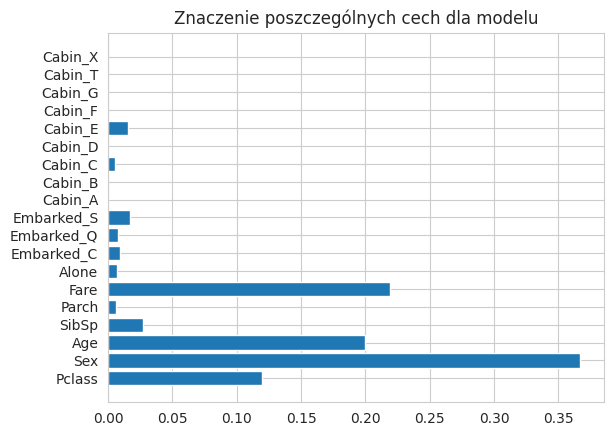

In [57]:
model = DecisionTreeClassifier(max_depth = 10, min_samples_split = 10, criterion = 'entropy')
single_training(df_normal, model)

importances = model.feature_importances_

feature_names = df.drop(columns=['Survived'], axis=1).columns.tolist()

plt.barh(feature_names, importances)
plt.title("Znaczenie poszczególnych cech dla modelu")
plt.show()

Zgodnie z przewidywaniami z poprzedniego zadania największe znaczenie ma płeć, później wiek, wydatki i klasa podróży. Zaskoczyło mnie zerowe znaczenie kolumny Alone.